# Testing response of an elastic plate with a cavity to remote loads using the Boundary element method
___
Rishav Mallick & Mark Simons
___
For many geodynamic problems, we consider the lithosphere of a planet as an elastic plate sitting on top of a viscous or viscoelastic substrate. In this notebook, we are interested in the icy moon Enceladus. We treat the icy lithospheric shell of the moon as an elastic plate sitting on an inviscid fluid, and are interested in investigating the role of heterogeneous materials within the shell in affecting surface displacements.

The following analysis is in 2-d plane strain. We first start with defining the important geometric parameters of the shell and the cavity inside.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from bem import geometry as gm
from bem import observations
import bem.greensfunctions as GF

# Define the coordinates of the rectangular box domain
H = 1 # vertical dimension
L = 2*H # horizontal dimension becomes 2*L because of symmetry
ngrid = 100 # number of points to mesh H

# Radius,depth of fluid-filled material (this is located at x = 0)
V_radiusx = 0.2*H
V_radiusz = 0.2*H
V_z0 = -0.3*H
rhog = -1/200 # density*g (normalized by shear modulus)
pval = -0 # uniform pressure inside the fluid-filled cavity
nellipse = 101 # number of points to mesh the ellipse boundary
Gshear = 1.# shear modulus in MPa

## Boundary conditions
After providing geometric parameters, we need to specify the boundary conditions for the problem. In the following case, we consider traction-free boundary at the top and bottom of the elastic plate. The lateral edges of the plate are subject to uniform and opposite displacements. The boundary of the cavity is presumably a fluid-solid interface, and we treat it as having 0 shear tractions $(\tau_s = 0)$ and the normal traction is a constant value of $\tau_n = p$.

The way to specify boundary conditions in this code is using variables `bcindices` and `bcvals`. 

`bcindicies` has 10 entries in the order 2 x top $\to$ 2 x right $\to$ 2 x bottom $\to$ 2 x left $\to$ 2 x internal boundary. 

Each boundary has 2 conditions because this is a plane strain system and so the displacements can be $u_x,u_z$ while the tractions are $\tau_s,\tau_n$ at each patch.

In [2]:
# boundary conditions
"""specify whether displacement or traction BCs
1 - traction BC
0 - displacement BC
2 - depth-dependent pressure (only for normal traction)
[top_s,top_n,
bot_s,bot_n,
left_s,left_n,
right_s,right_n
internal_s,internal_n]
"""
bcindices = np.array([1,1,# top
                      1,1,# bot
                      0,0,# left
                      0,0,# right
                      1,1])
# corresponding values at each of those boundaries
bcvals = np.array([0,0,# top
                   0,0,# bot
                   -1,0,# left
                   1,0,# right
                   0,pval])

We can plot the geometry of the elastic plate with a hole below. The red dots show the patch centers at which we will solve the boundary value problem, while the arrows show the normal vector to each patch surface.

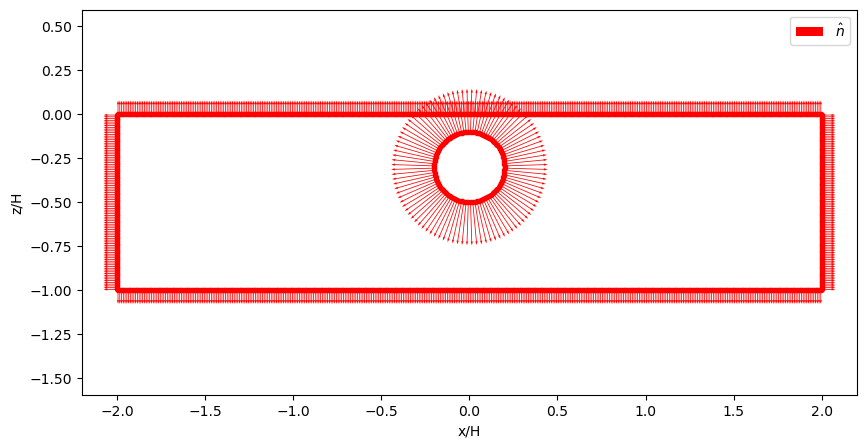

In [3]:
# meshing
corners = np.array([[-L, 0], [L, 0], [L, -H], [-L, -H], [-L, 0]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt((corners[i,0]-corners[(i+1),0])**2 + (corners[i,1]-corners[(i+1),1])**2)
    xi = np.linspace(corners[i][0], corners[(i + 1) % 4][0], num=round(lsegment*ngrid/H), endpoint=False)
    zi = np.linspace(corners[i][1], corners[(i + 1) % 4][1], num=round(lsegment*ngrid/H), endpoint=False)
    x.append(xi)
    z.append(zi)
x.append(corners[0,0])
z.append(corners[0,1])

x = np.hstack(x)
z = np.hstack(z)

# create a geometry object with those nodes
rcv = gm(x,z,G=Gshear)

# mesh an ellpise at (0,V_z0) with 2 radii specified
theta = np.linspace(0,-2*np.pi,nellipse)
x = V_radiusx*np.cos(theta)
z = V_radiusz*np.sin(theta) + V_z0

# create geometry object with those nodes
bnd = gm(x,z,G=Gshear)

# plot geometry
plt.figure(figsize=(10,5))
plt.plot(rcv.xn,rcv.zn,'k-',linewidth=0.5)
plt.plot(rcv.x,rcv.z,'r.')
plt.plot(bnd.xn,bnd.zn,'k-')
plt.plot(bnd.x,bnd.z,'r.')
plt.quiver(rcv.x,rcv.z,rcv.nv[:,0],rcv.nv[:,1],color='r', width=1e-3,label='$\hat{n}$')
# plt.quiver(rcv.x,rcv.z,rcv.dv[:,0],rcv.dv[:,1],color='b',width=1,label='$\hat{s}$')
plt.quiver(bnd.x,bnd.z,bnd.nv[:,0],bnd.nv[:,1],color='r', width=1e-3)
# plt.quiver(bnd.x,bnd.z,bnd.dv[:,0],bnd.dv[:,1],color='b',width=1)
plt.axis('equal')
plt.xlabel('x/H')
plt.ylabel('z/H')
plt.legend()
plt.show()

## Stiffness matrix and Boundary Conditions
To solve a boundary value problem using BEM, we need to set up a system of linear equations of the form $Ax = b$.

To calculate the system stiffness matrix $A$ we need to calculate impulse-response or Greens functions for tractions and displacements in the form of interaction kernels $K(x,z,x_0,z_0),G(x,z,x_0,z_0)$ respectively, where $(x,y)$ is an observation position while the source is placed at $(x_0,z_0)$. The interaction kernels are analytically integrated over the domain of each source patch such that each source represents spatially uniform slip on a finite fault.

Tractions are computed as: $\tau_s = \hat{n}.\sigma.\hat{s}$ and $\tau_n = \hat{n}.\sigma.\hat{n}$ in the shear (s) and normal (n) directions using the respective normal vectors, while $\sigma = \begin{bmatrix} \sigma_{xx} & \sigma_{xz} \\ \sigma_{xz} & \sigma_{zz} \end{bmatrix}$. 


In [4]:
# compute traction kernels
KKss,KKns,KKsn,KKnn = GF.compute_tractionkernel(rcv,rcv)
KLss,KLns,KLsn,KLnn = GF.compute_tractionkernel(rcv,bnd)
LKss,LKns,LKsn,LKnn = GF.compute_tractionkernel(bnd,rcv)
LLss,LLns,LLsn,LLnn = GF.compute_tractionkernel(bnd,bnd)
"""
K - outer boundary
L - internal boundary
LK - internal boundary on outside boundary
KL - outside boundary on internal boundary
sn - shear traction due to normal slip
ns - normal traction due to shear slip
"""
# compute displacement kernels
G_KK_xs,G_KK_zs,G_KK_xn,G_KK_zn = GF.compute_displacementkernel(rcv,rcv)
# G_KL_xs,G_KL_zs,G_KL_xn,G_KL_zn = GF.compute_displacementkernel(rcv,bnd)
G_LK_xs,G_LK_zs,G_LK_xn,G_LK_zn = GF.compute_displacementkernel(bnd,rcv)
# G_LL_xs,G_LL_zs,G_LL_xn,G_LL_zn = GF.compute_displacementkernel(bnd,bnd)

The boundary conditions $b$ need to be provided on the rectangular box as well as the boundary of the cavity. 

In [5]:
"""assemble boundary conditions as right hand side vector
s - s (traction) and x (displacement)
n - n (traction) and z (displacement)"""
rhs_s = np.zeros((rcv.N+bnd.N,1))
rhs_n = np.zeros((rcv.N+bnd.N,1))

# label boundaries
bcindex_ext = (bnd.z>0) # label the internal boundary as false
bcindex_top = np.concatenate(((rcv.z==0),bcindex_ext))
bcindex_bot = np.concatenate(((rcv.z==-H),bcindex_ext))
bcindex_left = np.concatenate(((rcv.x==-L),bcindex_ext))
bcindex_right = np.concatenate(((rcv.x==L),bcindex_ext))
bcindex_int = np.concatenate(((rcv.z>100),(~bcindex_ext)))

# specify boundary conditions
# top
bc_top_s = bcvals[0]*np.ones_like(np.where(bcindex_top)) 
bc_top_n = bcvals[1]*np.ones_like(np.where(bcindex_top)) 
rhs_s[bcindex_top,0] = bc_top_s
rhs_n[bcindex_top,0] = bc_top_n

# bottom
bc_bot_s = bcvals[2]*np.ones_like(np.where(bcindex_bot)) 
if bcindices[3]==2:
    bc_bot_n = rhog*rcv.z[rcv.z==-H]*np.ones_like(np.where(bcindex_bot)) # depth-dependent pressure
else:
    bc_bot_n = bcvals[3]*np.ones_like(np.where(bcindex_bot)) 
rhs_s[bcindex_bot,0] = bc_bot_s
rhs_n[bcindex_bot,0] = bc_bot_n

# left
bc_left_s = bcvals[4]*np.ones_like(np.where(bcindex_left)) 
bc_left_n = bcvals[5]*np.ones_like(np.where(bcindex_left))
# if bcindices[5]==2:
#     bc_left_n = rhog*rcv.z[rcv.x==-L]*np.ones_like(np.where(bcindex_left))# depth-dependent pressure
# else:
#     bc_left_n = bcvals[5]*np.ones_like(np.where(bcindex_left))
rhs_s[bcindex_left,0] = bc_left_s
rhs_n[bcindex_left,0] = bc_left_n

# right
bc_right_s = bcvals[6]*np.ones_like(np.where(bcindex_right)) 
if bcindices[7]==2:
    bc_right_n = rhog*rcv.z[rcv.x==L]*np.ones_like(np.where(bcindex_right))# depth-dependent pressure
else:
    bc_right_n = bcvals[7]*np.ones_like(np.where(bcindex_right))
rhs_s[bcindex_right,0] = bc_right_s
rhs_n[bcindex_right,0] = bc_right_n

# internal boundary
bc_int_s = bcvals[8]*np.ones_like(np.where(bcindex_int)) 
bc_int_n = bcvals[9]*np.ones_like(np.where(bcindex_int)) 
rhs_s[bcindex_int,0] = bc_int_s
rhs_n[bcindex_int,0] = bc_int_n

rhs = np.concatenate((rhs_s, rhs_n))

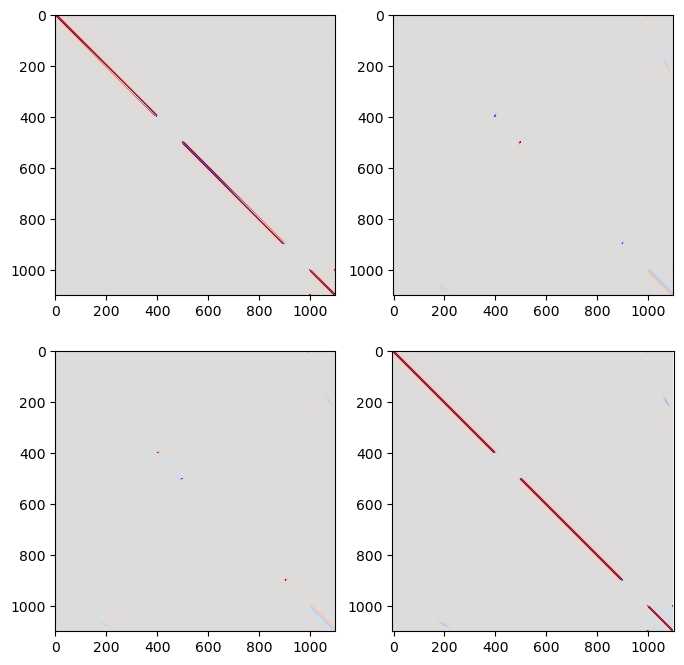

In [6]:
# Construct the matrices for linear inverse problem
# s - s (traction) and x (displacement)
# n - n (traction) and z (displacement)
As_s = np.zeros((rcv.N+bnd.N,rcv.N+bnd.N)) 
An_s = np.zeros((rcv.N+bnd.N,rcv.N+bnd.N)) 

As_n = np.zeros((rcv.N+bnd.N,rcv.N+bnd.N))
An_n = np.zeros((rcv.N+bnd.N,rcv.N+bnd.N))

# TOP BC
if bcindices[0]==1:# for shear traction bc
    As_s[bcindex_top] = np.concatenate((KKss[bcindex_top[0:rcv.N]],LKss[bcindex_top[0:rcv.N]]),axis=1)
    As_n[bcindex_top] = np.concatenate((KKsn[bcindex_top[0:rcv.N]],LKsn[bcindex_top[0:rcv.N]]),axis=1)    
else:# for x displacement bc
    As_s[bcindex_top] = 0#G_xs[bcindex_top[0:rcv.N]] 

if bcindices[1]==1: # for normal traction bc
    An_s[bcindex_top] = np.concatenate((KKns[bcindex_top[0:rcv.N]],LKns[bcindex_top[0:rcv.N]]),axis=1)
    An_n[bcindex_top] = np.concatenate((KKnn[bcindex_top[0:rcv.N]],LKnn[bcindex_top[0:rcv.N]]),axis=1)
else: # for z displacement bc
    An_s[bcindex_top] = 0#G_zs[bcindex_top[0:rcv.N]]

# BOTTOM BC
if bcindices[2]==1:# for shear traction bc
    As_s[bcindex_bot] = np.concatenate((KKss[bcindex_bot[0:rcv.N]],LKss[bcindex_bot[0:rcv.N]]),axis=1)
    As_n[bcindex_bot] = np.concatenate((KKsn[bcindex_bot[0:rcv.N]],LKsn[bcindex_bot[0:rcv.N]]),axis=1)
else:# for x displacement bc
    As_s[bcindex_bot] = 0#Gx_s[bcindex_bot]

if bcindices[3]!=0:# for normal traction bc
    An_s[bcindex_bot] = np.concatenate((KKns[bcindex_bot[0:rcv.N]],LKns[bcindex_bot[0:rcv.N]]),axis=1)
    An_n[bcindex_bot] = np.concatenate((KKnn[bcindex_bot[0:rcv.N]],LKnn[bcindex_bot[0:rcv.N]]),axis=1)
else:# for z displacement bc
    An_s[bcindex_bot] = np.concatenate((G_KK_zs[bcindex_bot[0:rcv.N]],G_LK_zs[bcindex_bot[0:rcv.N]]),axis=1)
    An_n[bcindex_bot] = np.concatenate((G_KK_zn[bcindex_bot[0:rcv.N]],G_LK_zn[bcindex_bot[0:rcv.N]]),axis=1)

# LEFT BC
if bcindices[4]==0:# for x displacement BC
    As_s[bcindex_left] = np.concatenate((G_KK_xs[bcindex_left[0:rcv.N]],G_LK_xs[bcindex_left[0:rcv.N]]),axis=1)
    As_n[bcindex_left] = np.concatenate((G_KK_xn[bcindex_left[0:rcv.N]],G_LK_xn[bcindex_left[0:rcv.N]]),axis=1)
else:# shear traction BC
    As_s[bcindex_left] = np.concatenate((KKss[bcindex_left[0:rcv.N]],LKss[bcindex_left[0:rcv.N]]),axis=1)
    As_n[bcindex_left] = np.concatenate((KKsn[bcindex_left[0:rcv.N]],LKsn[bcindex_left[0:rcv.N]]),axis=1)

if bcindices[5]==0: # for z displacement bc
    An_s[bcindex_left] = np.concatenate((G_KK_zs[bcindex_left[0:rcv.N]],G_LK_zs[bcindex_left[0:rcv.N]]),axis=1)
    An_n[bcindex_left] = np.concatenate((G_KK_zn[bcindex_left[0:rcv.N]],G_LK_zn[bcindex_left[0:rcv.N]]),axis=1)
else: # normal traction  BC      
    An_s[bcindex_left] = np.concatenate((KKns[bcindex_left[0:rcv.N]],LKns[bcindex_left[0:rcv.N]]),axis=1)
    An_n[bcindex_left] = np.concatenate((KKnn[bcindex_left[0:rcv.N]],LKnn[bcindex_left[0:rcv.N]]),axis=1)

# RIGHT BC
if bcindices[6]==0: # x displacement BC
    As_s[bcindex_right] = np.concatenate((G_KK_xs[bcindex_right[0:rcv.N]],G_LK_xs[bcindex_right[0:rcv.N]]),axis=1)
    As_n[bcindex_right] = np.concatenate((G_KK_xn[bcindex_right[0:rcv.N]],G_LK_xn[bcindex_right[0:rcv.N]]),axis=1)
else:
    As_s[bcindex_right] = np.concatenate((KKss[bcindex_right[0:rcv.N]],LKss[bcindex_right[0:rcv.N]]),axis=1)
    As_n[bcindex_right] = np.concatenate((KKsn[bcindex_right[0:rcv.N]],LKsn[bcindex_right[0:rcv.N]]),axis=1)

if bcindices[7]==0: # z displacement BC
    An_s[bcindex_right] = np.concatenate((G_KK_zs[bcindex_right[0:rcv.N]],G_LK_zs[bcindex_right[0:rcv.N]]),axis=1)
    An_n[bcindex_right] = np.concatenate((G_KK_zn[bcindex_right[0:rcv.N]],G_LK_zn[bcindex_right[0:rcv.N]]),axis=1)
else:
    An_s[bcindex_right] = np.concatenate((KKns[bcindex_right[0:rcv.N]],LKns[bcindex_right[0:rcv.N]]),axis=1)
    An_n[bcindex_right] = np.concatenate((KKnn[bcindex_right[0:rcv.N]],LKnn[bcindex_right[0:rcv.N]]),axis=1)

# INTERNAL BOUNDARY
if bcindices[8]==1: # shear traction BC
    As_s[bcindex_int] = np.concatenate((KLss[bcindex_int[rcv.N:]],LLss[bcindex_int[rcv.N:]]),axis=1)
    As_n[bcindex_int] = np.concatenate((KLsn[bcindex_int[rcv.N:]],LLsn[bcindex_int[rcv.N:]]),axis=1)    
else:# for x displacement bc
    As_s[bcindex_int] = 0#G_xs[bcindex_int[0:rcv.N]] 

if bcindices[9]==1: # normal traction BC
    An_s[bcindex_int] = np.concatenate((KLns[bcindex_int[rcv.N:]],LLns[bcindex_int[rcv.N:]]),axis=1)
    An_n[bcindex_int] = np.concatenate((KLnn[bcindex_int[rcv.N:]],LLnn[bcindex_int[rcv.N:]]),axis=1)    
else:# for z displacement bc
    As_s[bcindex_int] = 0#G_xs[bcindex_int[0:rcv.N]] 

# assemble big matrix
A = np.block([[As_s, As_n], [An_s, An_n]])

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
im = axs[0,0].imshow(As_s,cmap='coolwarm')
im.set_clim((-1,1))
plt.axis('equal')
im = axs[0,1].imshow(As_n,cmap='coolwarm')
im.set_clim((-1,1))
plt.axis('equal')
im = axs[1,0].imshow(An_s,cmap='coolwarm')
im.set_clim((-1,1))
plt.axis('equal')
im = axs[1,1].imshow(An_n,cmap='coolwarm')
im.set_clim((-1,1))
plt.axis('equal')
plt.show()

# plt.imshow(A,cmap = 'coolwarm')
# plt.colorbar()
# plt.clim((-10,10))
# plt.show()

## Solve Boundary Value Problem
Now that we have both $A$ and $b$, we can use matrix inversion to solve for the unknown slip or influence coefficients $x$. These ficticious slips are applied to the discretized boundaries to compute internal displacements and stresses.

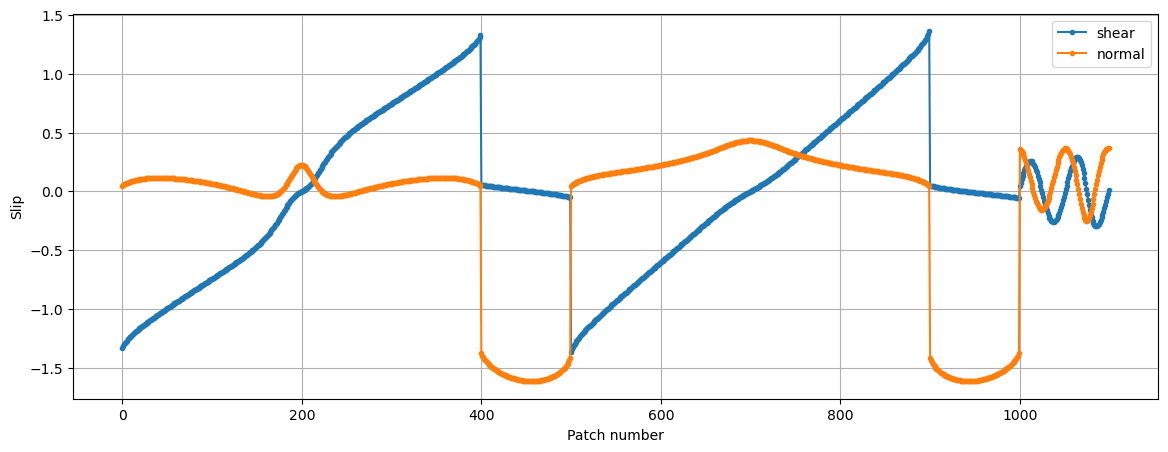

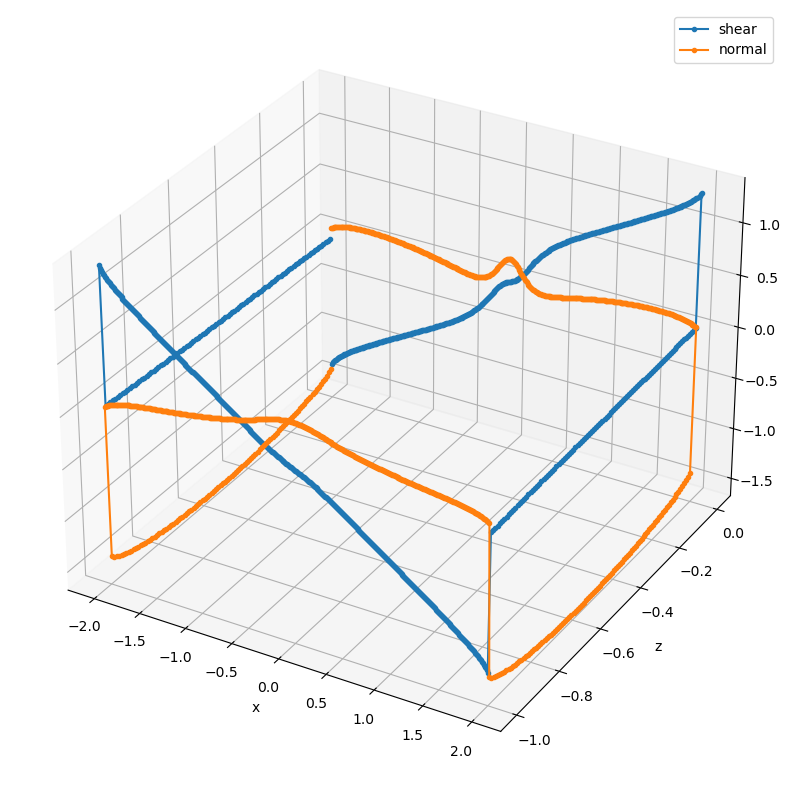

In [7]:
# solve the boundary value problem (BEM solve)
# solvec = np.linalg.solve(A,rhs)
solvec,_,_,_ = np.linalg.lstsq(A, rhs, rcond=None)

# extract solution into slip components for all boundaries
slip_s = solvec[0:rcv.N+bnd.N,0]
slip_n = solvec[rcv.N+bnd.N:,0]

plt.figure(figsize=(14,5))
plt.plot(slip_s,'.-',label='shear')
plt.plot(slip_n,'.-',label='normal')
plt.legend()
plt.ylabel('Slip')
plt.xlabel('Patch number')
plt.grid()
plt.show()

fig = plt.figure()
fig.add_subplot(projection='3d')
fig.set_size_inches((10,10))
plt.plot(rcv.x,rcv.z,slip_s[0:rcv.N],'.-',label='shear')
plt.plot(rcv.x,rcv.z,slip_n[0:rcv.N],'.-',label='normal')
plt.legend()
plt.ylabel('z')
plt.xlabel('x')
plt.grid()
plt.show()

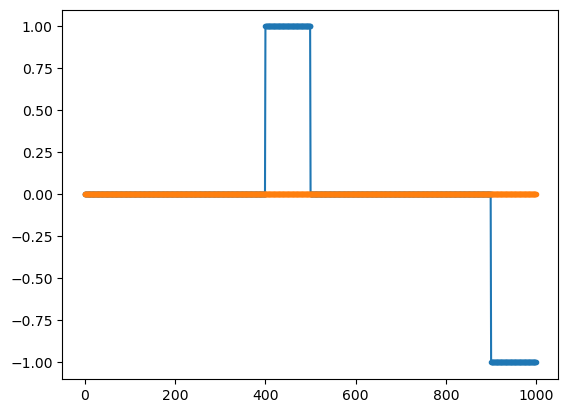

In [8]:
plt.plot((A@solvec)[0:rcv.N,0],'.-')
plt.plot((A@solvec)[rcv.N+bnd.N:2*rcv.N+bnd.N,0],'.-')
# plt.plot(rhs,'x')
plt.show()

## Plot internal displacements
We now have all the ingredients needed to predict displacements everywhere inside the domain. Note the domain refers to the rectangular box outside the fluid-filled cavity. Also for numerical reasons related to how the interaction kernels or Greens functions are calculated, it is best to calculate displacements an infinitesimal amount internal to the rectangular box. 

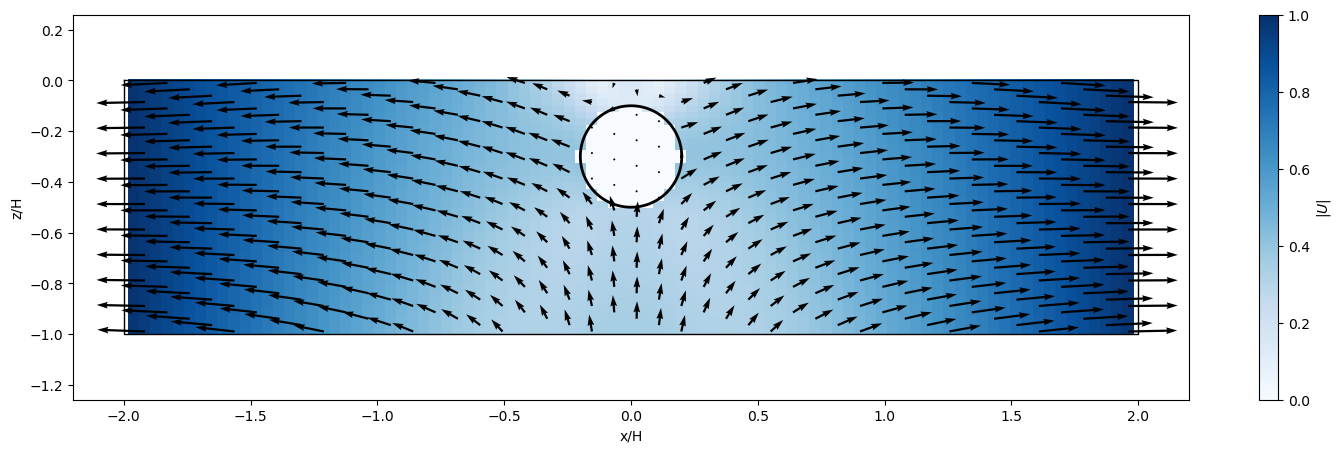

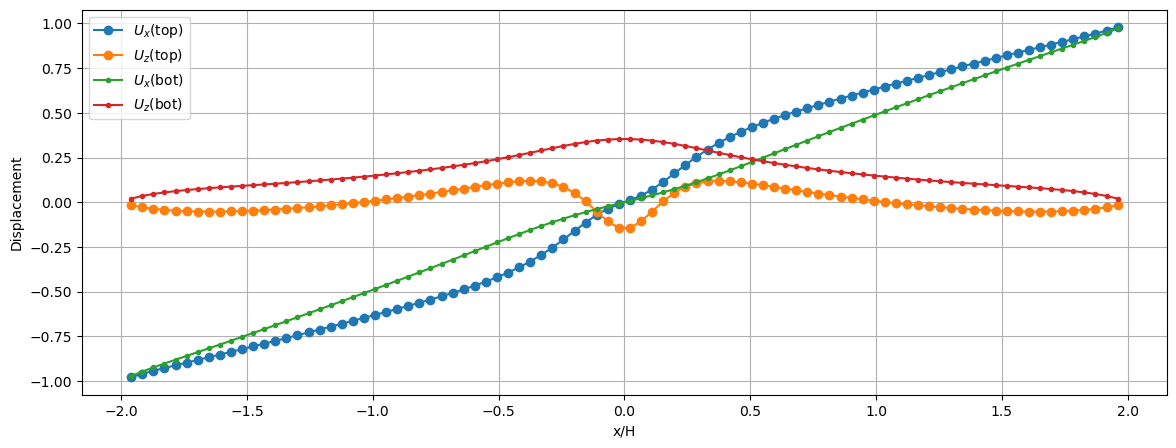

In [9]:
# compute displacements in the medium
xvec = np.linspace(-0.98*L,0.98*L,90)
zvec = np.linspace(-0.99*H,-0.01*H,40)
[X,Z] = np.meshgrid(xvec,zvec)
# create observer object
obs = observations(X.flatten(),Z.flatten())

# compute displacement kernels
G_Kox_s,G_Koz_s,G_Kox_n,G_Koz_n = GF.compute_displacementkernel(rcv,obs)
G_Lox_s,G_Loz_s,G_Lox_n,G_Loz_n = GF.compute_displacementkernel(bnd,obs)

# compute internal displacements
x_obs = G_Kox_s@slip_s[0:rcv.N] + G_Kox_n@slip_n[0:rcv.N] + G_Lox_s@slip_s[rcv.N:] + G_Lox_n@slip_n[rcv.N:]
z_obs = G_Koz_s@slip_s[0:rcv.N] + G_Koz_n@slip_n[0:rcv.N] + G_Loz_s@slip_s[rcv.N:] + G_Loz_n@slip_n[rcv.N:]

# remove values inside cavity
in_path = mpath.Path(np.vstack((bnd.x, bnd.z)).T)
in_idx = in_path.contains_points(np.vstack((obs.x, obs.z)).T)
x_obs[in_idx] = 0
z_obs[in_idx] = 0

Disp = np.sqrt(x_obs**2 + z_obs**2)
# grid spacing for arrows
ng = 8
plt.figure(figsize=(18,5))
plt.pcolor(xvec,zvec,Disp.reshape(len(zvec),len(xvec)),cmap='Blues',shading='auto')
plt.plot(bnd.xn,bnd.zn,'k-',linewidth=2)
plt.plot(rcv.xn,rcv.zn,'k-',linewidth=1)
plt.clim((0,1))
plt.colorbar(label='$|U|$')
plt.quiver(obs.x[1::ng],obs.z[1::ng],x_obs[1::ng],z_obs[1::ng],width=2e-3)
plt.xlabel('x/H')
plt.ylabel('z/H')
plt.axis('equal')
plt.show()

# plot surface displacements
plt.figure(figsize=(14,5))
index = np.where(obs.z < 0)
idx = (obs.z == np.max(obs.z[index]))
plt.plot(obs.x[idx],x_obs[idx],'o-',label='$U_x$(top)')
plt.plot(obs.x[idx],z_obs[idx],'o-',label='$U_z$(top)')
idx = (obs.z == np.min(obs.z[index]))
plt.plot(obs.x[idx],x_obs[idx],'.-',label='$U_x$(bot)')
plt.plot(obs.x[idx],z_obs[idx],'.-',label='$U_z$(bot)')
plt.axis('tight')
plt.xlabel('x/H')
plt.ylabel('Displacement')
plt.legend()
plt.grid()
plt.show()
# plt.plot(xvec,1/L*xvec,'k-',label='ramp')
# plt.plot(obs.x[idx],x_obs[idx]-1/L*obs.x[idx],'k.-',label='$U_x$ deramped')